# Some Figures from Depeg Detection Model runs

Exploratory notebook.

In [25]:
%load_ext autoreload
%autoreload 2

import ast
import os
import sys
import requests as req
import json
import multiprocessing as mp
import time
import asyncio
import ccxt
import pickle
import math

from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.modelsetup import ModelSetup
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.detection.scorer import early_weight
from curvemetrics.src.plotting.plot import bocd_plot_comp, run_length_plot
from curvemetrics.src.classes.model import BOCD, Baseline
from curvemetrics.src.classes.entities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Adding /root/curve-lp-metrics to sys.path


In [2]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)
datafetcher = DataFetcher(token_metadata=token_metadata)

In [87]:
from curvemetrics.scripts.forever import check_availability, latest_run, get_model_start, get_model_end
new_block, new_ts = asyncio.run(check_availability())
latest_block, latest_ts = latest_run()
print(new_block, new_ts, latest_block, latest_ts)

17480430 1686773051 17474472 1686700511


In [88]:
# start = latest_ts + 1 # Non-overlapping
# end = new_ts
start = datetime.timestamp(datetime(2023, 6, 10, 4, 34))
end = datetime.timestamp(datetime(2023, 6, 10, 5, 35))
model_start = get_model_start(start)
model_end = get_model_end(end)
print(datetime.fromtimestamp(model_start), datetime.fromtimestamp(model_end))

2023-06-10 03:00:00 2023-06-10 04:59:59.999990


In [86]:
pool = list(datahandler.pool_metadata.keys())[0]
X = datahandler.get_pool_X('shannonsEntropy', pool, model_start, model_end, '1h')
X

timestamp
2023-06-10 04:00:00   -0.000027
Freq: H, Name: shannonsEntropy, dtype: float64

In [81]:
for ts, x in X.items():
    print(ts, x)

2023-06-10 04:00:00 -2.7237065911899907e-05
2023-06-10 05:00:00 2.949078073490994e-05
2023-06-10 06:00:00 -0.00013388214415135545
2023-06-10 07:00:00 -0.00025054463479998033
2023-06-10 08:00:00 0.000156643426225648
2023-06-10 09:00:00 8.475351562459281e-05
2023-06-10 10:00:00 6.00122754688286e-05
2023-06-10 11:00:00 -2.576105232387423e-06
2023-06-10 12:00:00 1.0319517507629454e-07
2023-06-10 13:00:00 2.7586300173226427e-05
2023-06-10 14:00:00 -8.202653142297473e-06
2023-06-10 15:00:00 -4.264197661258365e-06
2023-06-10 16:00:00 -6.277269656807362e-08
2023-06-10 17:00:00 -3.341438658917455e-07
2023-06-10 18:00:00 1.2040343398870381e-05
2023-06-10 19:00:00 7.769436804254366e-05
2023-06-10 20:00:00 -8.714066365559492e-06
2023-06-10 21:00:00 1.7348631921835274e-05
2023-06-10 22:00:00 -4.193267297746162e-09
2023-06-10 23:00:00 -1.347095200024436e-08
2023-06-11 00:00:00 -1.076173067086644e-06
2023-06-11 01:00:00 -1.3180486082996238e-07
2023-06-11 02:00:00 -2.98746073983691e-07
2023-06-11 03:0

<Axes: xlabel='timestamp'>

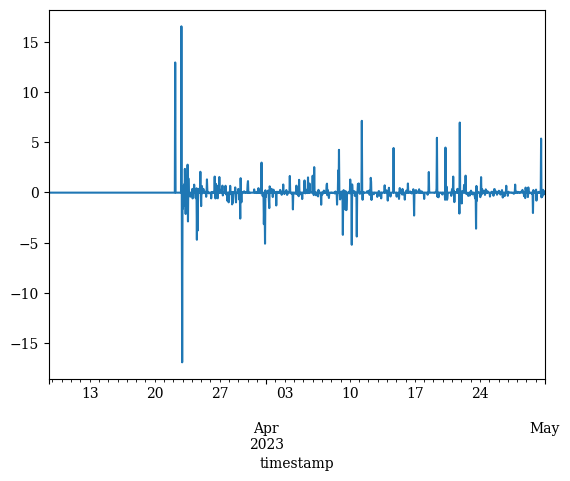

In [33]:
pool = "0x971add32ea87f10bd192671630be3be8a11b8623"
pool_start = datetime.timestamp(datetime.fromisoformat('2022-01-01'))
pool_end = datetime.timestamp(datetime.fromisoformat('2023-05-01'))

X = datahandler.get_pool_X('shannonsEntropy', pool, pool_start, pool_end, timedelta(hours=1), standardize=True)
X.plot()

In [48]:
import math
import time
from datetime import datetime, timedelta
import smtplib
import re
import os
from dotenv import load_dotenv
import json
from typing import Dict
import tweepy
from crontab import CronTab
import pickle
import traceback

from curvemetrics.scripts.raw_data import main as raw
from curvemetrics.scripts.metrics import main as metrics
from curvemetrics.scripts.takers import main as takers

from curvemetrics.src.classes.model import BOCD
from curvemetrics.src.classes.logger import Logger
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.modelsetup import ModelSetup

PERIOD = 60*60 # 1 hour
BUFFER = 60*10 # 10 minutes
WINDOW = timedelta(days=1) # Markout window for Sharks (5 minutes for markout metric)
SLIDING_WINDOW = timedelta(seconds=PERIOD)
RETRIES = 3

load_dotenv()

# Define your SMTP email server details
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587  # for starttls
STMP_LOGIN = "thomas@xenophonlabs.com"
SMTP_APP_PWD = os.getenv('SMTP_APP_PWD')

POOL_METRICS = {"shannonsEntropy", "netSwapFlow", "300.Markout"}
MODELED_POOLS = [
    "0xdc24316b9ae028f1497c275eb9192a3ea0f67022", # ETH/stETH
    "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7", # 3pool
    "0xdcef968d416a41cdac0ed8702fac8128a64241a2", # FRAX/USDC
    "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577", # ETH/frxETH
    # "0x828b154032950c8ff7cf8085d841723db2696056", # stETH Concentrated
]

def load_config():
    # Load the configuration
    s = os.path.join(os.path.abspath('config.json'))
    s = re.sub(r'(/root/curve-lp-metrics/).*', r'\1', s) + 'config.json'
    with open(s, "r") as config_file:
        config = json.load(config_file)
    return config

config = load_config()

def send_email(msg):
    # Establish server connection
    server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
    server.starttls()
    server.login(STMP_LOGIN, SMTP_APP_PWD)
    # server.sendmail(STMP_LOGIN, ["thomas@xenophonlabs.com", "max@xenophonlabs.com"], msg)
    server.sendmail(STMP_LOGIN, ["thomas@xenophonlabs.com"], msg)
    server.quit()

def send_email_on_error(exc, start, end):
    subject = f'Curvemetrics Model Catchup Failure {datetime.fromtimestamp(start)} : {datetime.fromtimestamp(end)}'
    body = f"An exception was raised during model catchup {exc}:\n\n{traceback.print_exc()}"
    msg = f'Subject: {subject}\n\n{body}'
    send_email(msg)

def send_email_on_changepoint(pool_name, metric, cp):
    subject = f'Curvemetrics Changepoint Detected'
    body = f"A changepoint was detected.\nPool: {pool_name}\nMetric: {metric}\nTime: {datetime.fromtimestamp(cp)}"
    msg = f'Subject: {subject}\n\n{body}'
    send_email(msg)

def get_model_start(dt):
    return int(datetime.timestamp(datetime(dt.year, dt.month, dt.day, dt.hour) - timedelta(hours=2)))

def get_model_end(dt):
    return int(datetime.timestamp(datetime(dt.year, dt.month, dt.day, dt.hour)))

def main(models, now):
    """
    This script does the following, in order, every hour, forever:

    1. Frontfill raw data
    2. Computes and frontfills metrics
    3. Computes and frontfills new takers stats and sharkflow metric
    4. Runs one inference step on all models and frontfills the results

    Fault tolerance:

    If steps (1-3) fail, the script will retry them 3 times, with a 10 second delay between each retry.
    If they still fail, the script will:
    1. Log the error
    2. Send an email to the Xenophon Labs team
    3. Tweet about the error
    4. Exit

    If step (4) fails for any model, the script will retry that model 3 times.
    If it still fails, the script will:
    1. Log the error
    2. Send an email to the Xenophon Labs team
    3. Tweet about the error
    4. Retire the failing model
    5. Continue to the next model
    """
    try:
        dt = datetime.fromtimestamp(now)
        model_start = get_model_start(dt)
        model_end = get_model_end(dt) - 0.00001

        datahandler = DataHandler()
        tuner = ModelSetup(datahandler, freq=timedelta(seconds=PERIOD))

        ### Model Inference
        for pool in MODELED_POOLS:

            name = datahandler.pool_metadata[pool]['name']
            
            baseline = models[pool]['baseline']

            lp_share_price = datahandler.get_pool_metric_last(pool, 'lpSharePrice')[0]

            if pool in tuner.ETH_POOLS:
                eth_price = datahandler.get_ohlcv_data_last(datahandler.token_ids['ETH'])['close'][0]
                lp_share_price /= eth_price
            elif pool in tuner.CRV_POOLS:
                crv_price = datahandler.get_ohlcv_data_last(datahandler.token_ids['CRV'])['close'][0]
                lp_share_price /= crv_price
            virtual_price = datahandler.get_pool_snapshots_last(pool)['virtualPrice'][0] / 10**18

            is_true_cp = baseline.update(virtual_price, lp_share_price, model_start)
            if is_true_cp:
                true_cp = baseline.last_cp
                # datahandler.insert_changepoints([datetime.fromtimestamp(true_cp)], pool, 'baseline', 'baseline', tuner.freq_str)
                print(f'Changepoint detected for {name} with baseline model at {datetime.fromtimestamp(true_cp)}.')

            for metric in POOL_METRICS:
                print(f'Running inference for {pool} with {metric} at {datetime.fromtimestamp(now)}.')
                model = models[pool][metric]
                X = datahandler.get_pool_X(metric, pool, model_start, model_end, '1h')
                x, ts = X[-1], datetime.timestamp(X.index[-1])
                # Ensure we are getting complete, non-overlapping data
                assert ts == model.last_ts + PERIOD 
                is_cp = model.predict(x, ts)
                if is_cp:
                    cp = now
                    # datahandler.insert_changepoints([datetime.fromtimestamp(cp)], pool, 'bocd', metric, tuner.freq_str)
                    print(f'Changepoint detected for {name} with {metric} at {datetime.fromtimestamp(cp)}.')
                    # send_email_on_changepoint(name, metric, cp)

    except Exception as e:
        print(f'Failed to run inference: {e}')
        # send_email_on_error(e, model_start, model_end)
        raise e

    finally:
        datahandler.close()

    return models

POOL_METRICS = {"shannonsEntropy", "netSwapFlow", "300.Markout"}
MODELED_POOLS = [
    "0xdc24316b9ae028f1497c275eb9192a3ea0f67022", # ETH/stETH
    "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7", # 3pool
    "0xdcef968d416a41cdac0ed8702fac8128a64241a2", # FRAX/USDC
    "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577", # ETH/frxETH
    # "0x828b154032950c8ff7cf8085d841723db2696056", # stETH Concentrated
]
models = {}
for pool in MODELED_POOLS:
    models[pool] = {}
    with open(f'../model_configs/baseline/{pool}.pkl', 'rb') as f:
        baseline = pickle.load(f)
    models[pool]['baseline'] = baseline 
    # print(f"{datahandler.pool_metadata[pool]['name']}, baseline: {baseline.last_ts}")
    for metric in POOL_METRICS:
        with open(f'../model_configs/{metric}/{pool}.pkl', 'rb') as f:
            model = pickle.load(f)
        models[pool][metric] = model
#         print(f"{datahandler.pool_metadata[pool]['name']}, {metric}: {model.last_ts}")

# # NOTE: Edit these
# now = datetime.timestamp(datetime(2023, 6, 13, 20, 0, 0, 1))
# end = datetime.timestamp(datetime.now())

# while now <= end:
#     models = main(models, now)
#     now += PERIOD
#     end = datetime.timestamp(datetime.now())

In [49]:
model.last_ts

1686715200.0

In [9]:
datetime.now()

datetime.datetime(2023, 6, 13, 21, 43, 26, 866052)

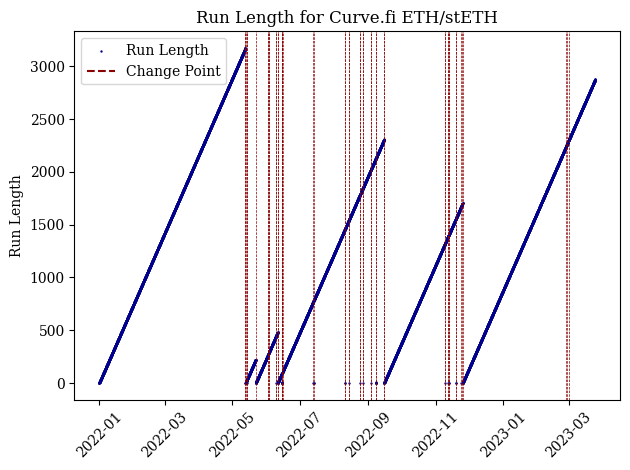

In [6]:
y = pd.Series(model.rt_mle)
y.index = pd.date_range(start='2022-01-01', end='2023-03-24 23', freq='1h')

run_length_plot(y, datahandler.pool_metadata[pool]['name'], fn='../figs/ethsteth_run_length_shannons.png', show=True, save=True)

In [38]:
pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" 

start_ts = datetime.timestamp(datetime(2023, 3, 1))
end_ts = datetime.timestamp(datetime(2023, 3, 11))

freq = '1h'
metric = "shannonsEntropy"

# swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
# lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
# pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)
# snapshots_data = datahandler.get_pool_snapshots(pool, start_ts, end_ts)
# m = datahandler.get_pool_metric(pool, metric, start_ts, end_ts)
# X = datahandler.get_pool_X(metric, pool, start_ts, end_ts, freq, normalize=False, standardize=True)
# takers = datahandler.get_takers()
# tokens = set(swaps_data['tokenBought']).union(set(swaps_data['tokenSold'])).union(set(pool_metadata[pool]['inputTokens']))
# ohlcvs = dict()
# for token in tokens:
#     ohlcvs[token] = datahandler.get_ohlcv_data(token, start_ts, end_ts)
#     display(ohlcvs[token].head())

In [16]:
pool = '0x971add32ea87f10bd192671630be3be8a11b8623'
start = max(datahandler.pool_metadata[pool]['creationDate'], datetime.timestamp(datetime(2022, 1, 1)))
end = datetime.timestamp(datetime(2023, 5, 1))
tuner = ModelSetup(datahandler)
y_true, lp_share_price, virtual_price, name = tuner.setup_pool(pool, start, end)

In [42]:
preds = {}
for metric in ['shannonsEntropy', 'giniCoefficient', 'netSwapFlow', 'netLPFlow', '300.Markout']:
    X = datahandler.get_pool_X(metric, pool, start_ts, end_ts, FREQ, standardize=True)
    params = ast.literal_eval(results.loc[pool, metric]['params'])
    model = BOCD(margin=MARGIN, alpha=ALPHA, verbose=True)
    model.update({'alpha':params['alpha'], 'beta':params['beta'], 'kappa':params['kappa']})
    y_pred, y_ps = model.predict(X)
    preds[metric] = y_pred

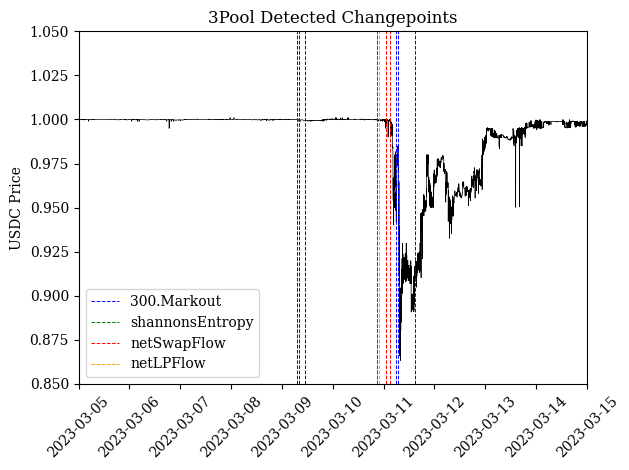

In [65]:
f, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'orange']
ax.plot(ohlcvs[usdc]['close'].index, ohlcvs[usdc]['close'], linewidth=0.5, color='black')
for i, metric in enumerate(['300.Markout', 'shannonsEntropy', 'netSwapFlow', 'netLPFlow']):
    c = colors[i]
    for y in preds[metric]:
        ax.axvline(y, color=c, linewidth=0.7, linestyle='--')
    ax.plot([], [], label=metric, color=c, linewidth=0.7, linestyle='--')

ax.legend()
ax.set_xlim(datetime(2023, 3, 5), datetime(2023, 3, 15))
ax.set_ylim(0.85, 1.05)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('USDC Price')
ax.set_title('3Pool Detected Changepoints')
f.tight_layout()
f.savefig('../figs/3pool_detected_cps.png')

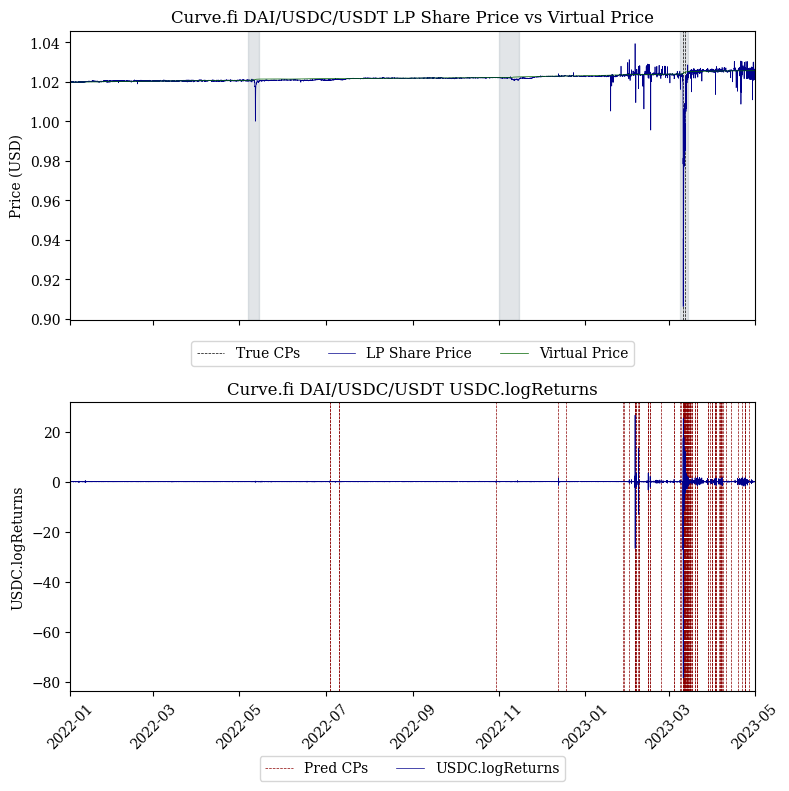

In [102]:
THRESH = 0.05
ALPHA = 1/5
FREQ = timedelta(hours=1)
MARGIN = timedelta(hours=24)

token = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
metric = 'USDC.logReturns'

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-01-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-05-01"))

ohlcv = datahandler.get_ohlcv_data(token, start_ts, end_ts)
ohlcv['peg'] = 1
peg = ohlcv['peg']
price = ohlcv['close']

y = metricsprocessor.true_cps(price, peg, freq=FREQ, thresh=THRESH)
X = datahandler.get_token_X(metric, token, start_ts, end_ts, FREQ)

model = BOCD(margin=MARGIN, alpha=ALPHA, verbose=True)
model.update({'alpha':10, 'beta':10, 'kappa':0.1})
y_pred, y_ps = model.predict(X)

bocd_plot_comp(X, lp_share_price.resample(FREQ).last(), virtual_price, y, y_pred, show=True, metric=metric, pool=pool_metadata[pool]['name'])